In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import category_encoders as ce
import os
import pickle
import gc
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
def encode_text_features(encode_decode, data_frame, encoder_isa=None, encoder_mem_type=None):
    # Implement Categorical OneHot encoding for ISA and mem-type
    if encode_decode == 'encode':
        encoder_isa = ce.one_hot.OneHotEncoder(cols=['isa'])
        encoder_mem_type = ce.one_hot.OneHotEncoder(cols=['mem-type'])
        encoder_isa.fit(data_frame, verbose=1)
        df_new1 = encoder_isa.transform(data_frame)
        encoder_mem_type.fit(df_new1, verbose=1)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
    else:
        df_new1 = encoder_isa.transform(data_frame)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
        
    return encoded_data_frame, encoder_isa, encoder_mem_type

In [10]:
df = pd.read_csv('dijkstra_power.csv')

In [11]:
df.head()

arch  cpu-clock     isa  l1d_assoc  \
0  IntelCorei97900X_DDR42666_2GB        3.3  X86_64          8   
1  IntelCorei97900X_DDR42666_3GB        3.3  X86_64          8   
2  IntelCorei97900X_DDR42666_4GB        3.3  X86_64          8   
3  IntelCorei97900X_DDR42666_6GB        3.3  X86_64          8   
4  IntelCorei78650U_DDR42400_2GB        1.9  X86_64          8   

   l1d_cache_lines  l1d_shared_by_threads  l1d_size  l2_assoc  l2_cache_lines  \
0               64                      1        32        16              64   
1               64                      1        32        16              64   
2               64                      1        32        16              64   
3               64                      1        32        16              64   
4               64                      1        32         4              64   

   l2_shared_by_threads  ...  l3_shared_by_threads  l3_size  mem-size  \
0                     1  ...                    10       16         2   
1                     1  ...                    10       16         3   
2                     1  ...                    10       16         4   
3                     1  ...                    10       16         6   
4                     1  ...                     4        8         2   

   mem-type  mem_clock  num-cpus                              arch1   PS  \
0      DDR4       2666        10  IntelCorei97900X_DDR42666_2GB_100  100   
1      DDR4       2666        10  IntelCorei97900X_DDR42666_3GB_100  100   
2      DDR4       2666        10  IntelCorei97900X_DDR42666_4GB_100  100   
3      DDR4       2666        10  IntelCorei97900X_DDR42666_6GB_100  100   
4      DDR4       2400         4  IntelCorei78650U_DDR42400_2GB_100  100   

   runtime    power  
0    25523  11.1726  
1    25523  11.1726  
2    25523  11.1726  
3    25523  11.1726  
4    44434  10.5760  

[5 rows x 23 columns]

In [12]:
df.columns, len(df.columns)

(Index(['arch', 'cpu-clock', 'isa', 'l1d_assoc', 'l1d_cache_lines',
        'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
        'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
        'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type', 'mem_clock',
        'num-cpus', 'arch1', 'PS', 'runtime', 'power'],
       dtype='object'), 23)

In [13]:
len(df)

362

In [14]:
encoded_data_frame, encoder_isa, encoder_mem_type = encode_text_features('encode', df, encoder_isa = None, encoder_mem_type=None)

In [15]:
encoded_data_frame.head()

arch  cpu-clock  isa_1  isa_2  l1d_assoc  \
0  IntelCorei97900X_DDR42666_2GB        3.3      1      0          8   
1  IntelCorei97900X_DDR42666_3GB        3.3      1      0          8   
2  IntelCorei97900X_DDR42666_4GB        3.3      1      0          8   
3  IntelCorei97900X_DDR42666_6GB        3.3      1      0          8   
4  IntelCorei78650U_DDR42400_2GB        1.9      1      0          8   

   l1d_cache_lines  l1d_shared_by_threads  l1d_size  l2_assoc  l2_cache_lines  \
0               64                      1        32        16              64   
1               64                      1        32        16              64   
2               64                      1        32        16              64   
3               64                      1        32        16              64   
4               64                      1        32         4              64   

   ...  mem-type_1  mem-type_2  mem-type_3  mem-type_4  mem_clock  num-cpus  \
0  ...           1           0           0           0       2666        10   
1  ...           1           0           0           0       2666        10   
2  ...           1           0           0           0       2666        10   
3  ...           1           0           0           0       2666        10   
4  ...           1           0           0           0       2400         4   

                               arch1   PS  runtime    power  
0  IntelCorei97900X_DDR42666_2GB_100  100    25523  11.1726  
1  IntelCorei97900X_DDR42666_3GB_100  100    25523  11.1726  
2  IntelCorei97900X_DDR42666_4GB_100  100    25523  11.1726  
3  IntelCorei97900X_DDR42666_6GB_100  100    25523  11.1726  
4  IntelCorei78650U_DDR42400_2GB_100  100    44434  10.5760  

[5 rows x 27 columns]

In [16]:
encoded_data_frame.columns

Index(['arch', 'cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus',
       'arch1', 'PS', 'runtime', 'power'],
      dtype='object')

In [17]:
total_data = encoded_data_frame.drop(columns = ['arch', 'arch1'])

In [18]:
total_data.columns

Index(['cpu-clock', 'isa_1', 'isa_2', 'l1d_assoc', 'l1d_cache_lines',
       'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
       'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
       'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
       'mem-type_2', 'mem-type_3', 'mem-type_4', 'mem_clock', 'num-cpus', 'PS',
       'runtime', 'power'],
      dtype='object')

In [20]:
X_columns = total_data.drop(columns = 'PS').columns
X = total_data.drop(columns =['PS' , 'runtime' , 'power']).to_numpy()
Y = total_data[['runtime','power']].to_numpy()

In [21]:
X.shape, Y.shape

((362, 22), (362, 2))

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((289, 22), (73, 22), (289, 2), (73, 2))

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Y_train = scaler.fit_transform(Y_train)
# Y_test = scaler.fit_transform(Y_test)

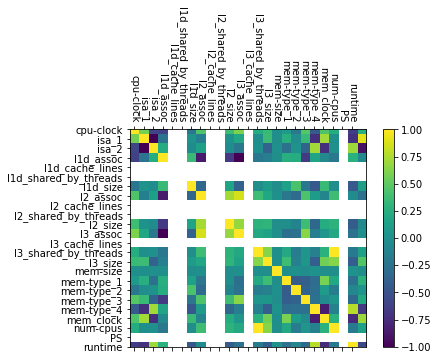

<Figure size 1440x1080 with 0 Axes>

In [25]:
train_data = total_data
correlations = train_data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,24,1)
#ticks = np.arange(0,12,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(train_data.columns, rotation = -90)
ax.set_yticklabels(train_data.columns)
plt.figure(figsize=(20,15))
plt.show()

In [26]:
def absolute_percentage_error(Y_test, Y_pred):
    error = 0
    for i in range(len(Y_test)):
        error = error + (abs(Y_test[i] - Y_pred[i]))/Y_test[i]
        
    error = error/ len(Y_test)
    return error

# 2. Linear Regression + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] fit_intercept=True, normalize=True ..............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] .. fit_intercept=True, normalize=True, score=0.895, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] .. fit_intercept=True, normalize=True, score=0.892, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] .. fit_intercept=True, normalize=True, score=0.871, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . fit_intercept=True, normalize=False, score=0.895, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . fit_intercept=True, normalize=False, score=0.892, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . fit_intercept=True, normalize=False, score=0.871, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=True, score=-0.947, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=True, score=-2.130, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=True, score=-1.161, total=   0.0s
[CV] fit_intercept=False, normalize=False ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=False, score=-0.947, total=   0.0s
[CV] fit_intercept=False, normalize=False ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=False, score=-2.130, total=   0.0s
[CV] fit_intercept=False, normalize=False ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=False, score=-1.161, total=   0.0s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'fit_intercept': True, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
MSE =  69090785.25194047
MAE =  3617.38174523668
R2 score = 0.9330535026018669

Mean Absolute Percentage Error = [0.14433133 0.42393008]


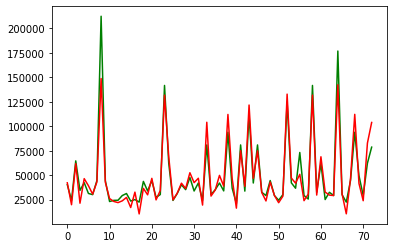

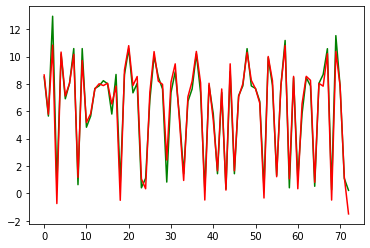

In [30]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
# defining parameter range 
param_grid = {'fit_intercept': [True, False],  
             'normalize' : [True, False], 
             } 
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
Y_pred = grid.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
print('MAE = ', mean_absolute_error(Y_test,Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
plt.plot(Y_test[:,0], 'g')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_test[:,1],'g')
plt.plot(Y_pred[:,1],'r')

print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))

In [48]:
Y_pred[:,1]

array([ 8.65003886,  5.77929348, 10.83384851, -0.74504769, 10.32457784,
        7.12117844,  8.04422068, 10.15713588,  1.16911417,  9.70665717,
        5.18488631,  5.82582107,  7.63650726,  8.00586508,  7.87535718,
        8.04641867,  6.53181495,  7.83623348, -0.50848969,  9.01719152,
       10.79199636,  7.88268199,  8.53696235,  1.06079208,  0.33649192,
        7.38602437, 10.35924636,  8.20240323,  7.96259059,  2.43198673,
        8.11921068,  9.46285933,  5.33165785,  0.9420319 ,  7.0469406 ,
        8.19754276, 10.37110542,  8.07694773, -0.48739092,  8.04535769,
        5.37017162,  1.64651628,  7.62789056,  0.2368748 ,  9.46428088,
        1.64935937,  7.05286534,  8.00870817, 10.30067624,  8.25796841,
        7.63935035,  6.59219725, -0.3401353 , 10.00139338,  8.23447681,
        1.21368483,  7.85948164, 10.80210455,  1.05937054,  8.54835145,
        0.33507037,  6.53039341,  8.54977299,  8.25938995,  0.80798105,
        8.0385345 ,  7.83339039, 10.20224192, -0.49023401, 10.36

# 3. Ridge Regression + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=0.864, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=0.884, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=0.857, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=0.864, total=   0.1s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=0.884, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=0.857, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=0.864, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=0.884, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=0.857, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr, score=0.864, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr, score=0.884, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr, score=0.857, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.864, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.884, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.857, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sag, score=0.864, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sag, score=0.884, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sag, score=0.857, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=saga, score=0.864, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=saga, score=0.884, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=saga, score=0.857, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=auto, score=0.895, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=auto, score=0.893, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=auto, score=0.871, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=svd, score=0.895, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=svd, score=0.893, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=svd, score=0.871, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky, score=0.895, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky, score=0.893, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky, score=0.871, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr, score=0.895, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr, score=0.893, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr, score=0.871, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.895, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.893, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.868, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sag, score=0.895, total=   0.1s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sag, score=0.893, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sag, score=0.870, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=saga, score=0.895, total=   0.1s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=saga, score=0.893, total=   0.1s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=saga, score=0.870, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=auto, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=auto, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=auto, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=svd, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=svd, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=svd, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr, score=-0.944, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr, score=-2.112, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr, score=-1.156, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg, score=-0.948, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sag, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sag, score=-2.127, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sag, score=-1.160, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=saga, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=saga, score=-2.126, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=saga, score=-1.160, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=auto, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=auto, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=auto, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=svd, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=svd, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=svd, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr, score=-0.944, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr, score=-2.112, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr, score=-1.156, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg, score=-0.948, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg, score=-2.127, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.160, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sag, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sag, score=-2.127, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sag, score=-1.160, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=saga, score=-0.947, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=saga, score=-2.126, total=   0.1s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=saga, score=-1.160, total=   0.1s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=auto ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=auto, score=0.735, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=auto ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=auto, score=0.855, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=auto ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=auto, score=0.747, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=svd .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=svd, score=0.735, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=svd .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=svd, score=0.855, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=svd .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=svd, score=0.747, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=cholesky ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=cholesky, score=0.735, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=cholesky ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=cholesky, score=0.855, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=cholesky ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=cholesky, score=0.747, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=lsqr ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=lsqr, score=0.735, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=lsqr ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=lsqr, score=0.855, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=lsqr ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=lsqr, score=0.747, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.735, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.855, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.747, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=0.735, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=0.855, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=0.747, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=0.735, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=0.855, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=0.747, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=auto, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=auto, score=0.894, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=auto, score=0.870, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=svd, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=svd, score=0.894, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=svd, score=0.870, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=cholesky, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=cholesky, score=0.894, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=cholesky, score=0.870, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=lsqr, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=lsqr, score=0.894, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=lsqr, score=0.870, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.870, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sag, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sag, score=0.894, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sag, score=0.870, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=saga, score=0.893, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=saga, score=0.894, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=saga, score=0.870, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=auto, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=auto, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=auto, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=svd, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=svd, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=svd, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=cholesky, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=cholesky, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=cholesky, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=lsqr, score=-0.944, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=lsqr, score=-2.112, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=lsqr, score=-1.155, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sag, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sag, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sag, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=saga, score=-0.948, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=saga, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=saga, score=-1.157, total=   0.1s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=auto, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=auto, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=auto, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=svd, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=svd, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=svd, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=cholesky, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=cholesky, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=cholesky, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=lsqr, score=-0.944, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=lsqr, score=-2.112, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=lsqr, score=-1.155, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sag, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sag, score=-2.120, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sag, score=-1.157, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=saga, score=-0.949, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=saga, score=-2.120, total=   0.1s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=saga, score=-1.157, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=auto, score=0.327, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=auto, score=0.468, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=auto, score=0.379, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=svd, score=0.327, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=svd, score=0.468, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=svd, score=0.379, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=cholesky, score=0.327, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=cholesky, score=0.468, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=cholesky, score=0.379, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=lsqr, score=0.327, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=lsqr, score=0.468, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=lsqr, score=0.379, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.327, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.468, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.379, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sag, score=0.327, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sag, score=0.468, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sag, score=0.379, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=saga, score=0.326, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=saga, score=0.468, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=saga, score=0.379, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=auto, score=0.879, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=auto, score=0.888, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=auto, score=0.866, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=svd, score=0.879, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=svd, score=0.888, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=svd, score=0.866, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=cholesky, score=0.879, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=cholesky, score=0.888, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=cholesky, score=0.866, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.878, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.888, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.866, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.878, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.888, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.866, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sag, score=0.879, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sag, score=0.888, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sag, score=0.866, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=saga, score=0.878, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=saga, score=0.887, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=saga, score=0.866, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=auto, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=auto, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=auto, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=svd, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=svd, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=svd, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=cholesky, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=cholesky, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=cholesky, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=lsqr, score=-0.968, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=lsqr, score=-2.079, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=lsqr, score=-1.155, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg, score=-0.968, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sag, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sag, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sag, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=saga, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=saga, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=saga, score=-1.154, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=auto, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=auto, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=auto, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=svd, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=svd, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=svd, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=cholesky, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=cholesky, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=cholesky, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=lsqr, score=-0.968, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=lsqr, score=-2.079, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=lsqr, score=-1.155, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg, score=-0.968, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sag, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sag, score=-2.075, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sag, score=-1.153, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=saga, score=-0.969, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=saga, score=-2.076, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=saga, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=auto, score=0.025, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=auto, score=0.050, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=auto, score=0.061, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=svd, score=0.025, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=svd, score=0.050, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=svd, score=0.061, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=cholesky, score=0.025, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=cholesky, score=0.050, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=cholesky, score=0.061, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=lsqr, score=0.025, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=lsqr, score=0.050, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=lsqr, score=0.061, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.025, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.050, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.061, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sag, score=0.025, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sag, score=0.050, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sag, score=0.061, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=saga, score=0.025, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=saga, score=0.050, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=saga, score=0.061, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=auto, score=0.792, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=auto, score=0.872, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=auto, score=0.795, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=svd, score=0.792, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=svd, score=0.872, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=svd, score=0.795, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=cholesky, score=0.792, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=cholesky, score=0.872, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=cholesky, score=0.795, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=lsqr, score=0.792, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=lsqr, score=0.872, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=lsqr, score=0.795, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.792, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.872, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.795, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sag, score=0.792, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sag, score=0.872, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sag, score=0.795, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=saga, score=0.791, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=saga, score=0.872, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=saga, score=0.795, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=auto, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=auto, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=auto, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=lsqr, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=lsqr, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=lsqr, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sag, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sag, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sag, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=saga, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=saga, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=saga, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=auto, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=auto, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=auto, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=svd, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=svd, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=svd, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=cholesky, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=cholesky, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=cholesky, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=lsqr, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=lsqr, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=lsqr, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sag, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sag, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sag, score=-1.154, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=saga, score=-1.059, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=saga, score=-1.880, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=saga, score=-1.154, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=auto, score=-0.025, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=auto, score=-0.024, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=auto, score=0.005, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=svd, score=-0.025, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=svd, score=-0.024, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=svd, score=0.005, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=cholesky, score=-0.025, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=cholesky, score=-0.024, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=cholesky, score=0.005, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=lsqr, score=-0.025, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=lsqr, score=-0.024, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=lsqr, score=0.005, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.025, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.024, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.005, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sag, score=-0.025, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sag, score=-0.024, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sag, score=0.005, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=saga, score=-0.025, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=saga, score=-0.024, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=saga, score=0.005, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=auto, score=0.471, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=auto, score=0.640, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=auto, score=0.516, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=svd, score=0.471, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=svd, score=0.640, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=svd, score=0.516, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=cholesky, score=0.471, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=cholesky, score=0.640, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=cholesky, score=0.516, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=lsqr, score=0.471, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=lsqr, score=0.640, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=lsqr, score=0.516, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.471, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.640, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.516, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sag, score=0.471, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sag, score=0.640, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sag, score=0.515, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=saga, score=0.471, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=saga, score=0.640, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=saga, score=0.515, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=auto, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=auto, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=auto, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=svd, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=svd, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=svd, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=cholesky, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=cholesky, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=cholesky, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=lsqr, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=lsqr, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=lsqr, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=auto ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=auto, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=auto ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=auto, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=auto ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=auto, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=svd ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=svd, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=svd ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=svd, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=svd ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=svd, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=cholesky, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=cholesky, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=cholesky, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=lsqr ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=lsqr, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=lsqr ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=lsqr, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=lsqr ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=lsqr, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sag ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sag, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sag ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sag, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sag ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sag, score=-1.341, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=saga ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=saga, score=-1.393, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=saga ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=saga, score=-1.844, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=saga ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=saga, score=-1.341, total=   0.0s


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    8.2s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.1, 'fit_intercept': True, 'normalize': False, 'solver': 'svd'}
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='svd', tol=0.001)
MSE =  69101087.7745371
R2 score = 0.9330551573747473

Mean Absolute Percentage Error = [0.14333119 0.42348585]


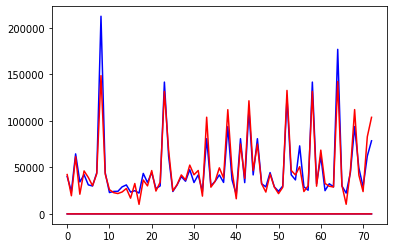

In [31]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=1.0, fit_intercept=True, 
                         normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# defining parameter range 
param_grid = {'alpha': [0.1, 1, 10, 100, 1000],  
             'fit_intercept' : [True, False],
              'normalize' :[True, False],
              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
             } 
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))

# 4. K-Nearest Neighbors + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=2, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.931, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] n_neighbors=2, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.923, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] n_neighbors=2, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.879, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=1, weights=distance, score=0.935, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=1, weights=distance, score=0.931, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=1, weights=distance, score=0.894, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=2, weights=uniform, score=0.913, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=2, weights=uniform, score=0.920, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=2, weights=uniform, score=0.873, total=   0.0s
[CV] n_neighbors=2, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=2, weights=distance, score=0.923, total=   0.0s
[CV] n_neighbors=2, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=2, weights=distance, score=0.928, total=   0.0s
[CV] n_neighbors=2, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=2, weights=distance, score=0.885, total=   0.0s
[CV] n_neighbors=2, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=4, weights=uniform, score=0.890, total=   0.0s
[CV] n_neighbors=2, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=4, weights=uniform, score=0.890, total=   0.0s
[CV] n_neighbors=2, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=4, weights=uniform, score=0.875, total=   0.0s
[CV] n_neighbors=2, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=4, weights=distance, score=0.913, total=   0.0s
[CV] n_neighbors=2, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=4, weights=distance, score=0.906, total=   0.0s
[CV] n_neighbors=2, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=4, weights=distance, score=0.885, total=   0.0s
[CV] n_neighbors=2, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=5, weights=uniform, score=0.899, total=   0.0s
[CV] n_neighbors=2, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=5, weights=uniform, score=0.890, total=   0.0s
[CV] n_neighbors=2, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=5, weights=uniform, score=0.875, total=   0.0s
[CV] n_neighbors=2, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=5, weights=distance, score=0.917, total=   0.0s
[CV] n_neighbors=2, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=5, weights=distance, score=0.906, total=   0.0s
[CV] n_neighbors=2, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=5, weights=distance, score=0.885, total=   0.0s
[CV] n_neighbors=2, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=7, weights=uniform, score=0.858, total=   0.0s
[CV] n_neighbors=2, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=7, weights=uniform, score=0.889, total=   0.0s
[CV] n_neighbors=2, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=7, weights=uniform, score=0.855, total=   0.0s
[CV] n_neighbors=2, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=7, weights=distance, score=0.888, total=   0.0s
[CV] n_neighbors=2, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=7, weights=distance, score=0.905, total=   0.0s
[CV] n_neighbors=2, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=7, weights=distance, score=0.871, total=   0.0s
[CV] n_neighbors=2, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=uniform, score=0.858, total=   0.0s
[CV] n_neighbors=2, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=uniform, score=0.889, total=   0.0s
[CV] n_neighbors=2, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=uniform, score=0.855, total=   0.0s
[CV] n_neighbors=2, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=distance, score=0.888, total=   0.0s
[CV] n_neighbors=2, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=distance, score=0.905, total=   0.0s
[CV] n_neighbors=2, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=distance, score=0.871, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=1, weights=uniform, score=0.905, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=1, weights=uniform, score=0.938, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=1, weights=uniform, score=0.900, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=1, weights=distance, score=0.928, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=1, weights=distance, score=0.942, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=1, weights=distance, score=0.918, total=   0.0s
[CV] n_neighbors=3, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=2, weights=uniform, score=0.864, total=   0.0s
[CV] n_neighbors=3, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=2, weights=uniform, score=0.928, total=   0.0s
[CV] n_neighbors=3, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=2, weights=uniform, score=0.860, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=2, weights=distance, score=0.898, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=2, weights=distance, score=0.933, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=2, weights=distance, score=0.875, total=   0.0s
[CV] n_neighbors=3, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=4, weights=uniform, score=0.849, total=   0.0s
[CV] n_neighbors=3, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=4, weights=uniform, score=0.928, total=   0.0s
[CV] n_neighbors=3, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=4, weights=uniform, score=0.856, total=   0.0s
[CV] n_neighbors=3, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=4, weights=distance, score=0.885, total=   0.0s
[CV] n_neighbors=3, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=4, weights=distance, score=0.932, total=   0.0s
[CV] n_neighbors=3, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=4, weights=distance, score=0.872, total=   0.0s
[CV] n_neighbors=3, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=5, weights=uniform, score=0.861, total=   0.0s
[CV] n_neighbors=3, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=5, weights=uniform, score=0.927, total=   0.0s
[CV] n_neighbors=3, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=5, weights=uniform, score=0.858, total=   0.0s
[CV] n_neighbors=3, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=5, weights=distance, score=0.896, total=   0.0s
[CV] n_neighbors=3, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=5, weights=distance, score=0.932, total=   0.0s
[CV] n_neighbors=3, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=5, weights=distance, score=0.873, total=   0.0s
[CV] n_neighbors=3, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=7, weights=uniform, score=0.806, total=   0.0s
[CV] n_neighbors=3, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=7, weights=uniform, score=0.927, total=   0.0s
[CV] n_neighbors=3, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=7, weights=uniform, score=0.838, total=   0.0s
[CV] n_neighbors=3, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=7, weights=distance, score=0.853, total=   0.0s
[CV] n_neighbors=3, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=7, weights=distance, score=0.932, total=   0.0s
[CV] n_neighbors=3, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=7, weights=distance, score=0.862, total=   0.0s
[CV] n_neighbors=3, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=uniform, score=0.806, total=   0.0s
[CV] n_neighbors=3, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=uniform, score=0.928, total=   0.0s
[CV] n_neighbors=3, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=uniform, score=0.839, total=   0.0s
[CV] n_neighbors=3, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=distance, score=0.852, total=   0.0s
[CV] n_neighbors=3, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=distance, score=0.932, total=   0.0s
[CV] n_neighbors=3, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=distance, score=0.861, total=   0.0s
[CV] n_neighbors=4, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=1, weights=uniform, score=0.905, total=   0.0s
[CV] n_neighbors=4, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=1, weights=uniform, score=0.917, total=   0.0s
[CV] n_neighbors=4, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=1, weights=uniform, score=0.891, total=   0.0s
[CV] n_neighbors=4, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=1, weights=distance, score=0.925, total=   0.0s
[CV] n_neighbors=4, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=1, weights=distance, score=0.936, total=   0.0s
[CV] n_neighbors=4, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=1, weights=distance, score=0.913, total=   0.0s
[CV] n_neighbors=4, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=2, weights=uniform, score=0.877, total=   0.0s
[CV] n_neighbors=4, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=2, weights=uniform, score=0.923, total=   0.0s
[CV] n_neighbors=4, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=2, weights=uniform, score=0.891, total=   0.0s
[CV] n_neighbors=4, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=2, weights=distance, score=0.904, total=   0.0s
[CV] n_neighbors=4, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=2, weights=distance, score=0.937, total=   0.0s
[CV] n_neighbors=4, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=2, weights=distance, score=0.897, total=   0.0s
[CV] n_neighbors=4, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=4, weights=uniform, score=0.850, total=   0.0s
[CV] n_neighbors=4, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=4, weights=uniform, score=0.919, total=   0.0s
[CV] n_neighbors=4, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=4, weights=uniform, score=0.859, total=   0.0s
[CV] n_neighbors=4, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=4, weights=distance, score=0.885, total=   0.0s
[CV] n_neighbors=4, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=4, weights=distance, score=0.935, total=   0.0s
[CV] n_neighbors=4, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=4, weights=distance, score=0.875, total=   0.0s
[CV] n_neighbors=4, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=5, weights=uniform, score=0.835, total=   0.0s
[CV] n_neighbors=4, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=5, weights=uniform, score=0.920, total=   0.0s
[CV] n_neighbors=4, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=5, weights=uniform, score=0.860, total=   0.0s
[CV] n_neighbors=4, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=5, weights=distance, score=0.875, total=   0.0s
[CV] n_neighbors=4, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=5, weights=distance, score=0.935, total=   0.0s
[CV] n_neighbors=4, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=5, weights=distance, score=0.875, total=   0.0s
[CV] n_neighbors=4, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=7, weights=uniform, score=0.786, total=   0.0s
[CV] n_neighbors=4, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=7, weights=uniform, score=0.919, total=   0.0s
[CV] n_neighbors=4, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=7, weights=uniform, score=0.840, total=   0.0s
[CV] n_neighbors=4, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=7, weights=distance, score=0.838, total=   0.0s
[CV] n_neighbors=4, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=7, weights=distance, score=0.934, total=   0.0s
[CV] n_neighbors=4, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=7, weights=distance, score=0.865, total=   0.0s
[CV] n_neighbors=4, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=uniform, score=0.787, total=   0.0s
[CV] n_neighbors=4, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=uniform, score=0.920, total=   0.0s
[CV] n_neighbors=4, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=uniform, score=0.835, total=   0.0s
[CV] n_neighbors=4, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=distance, score=0.838, total=   0.0s
[CV] n_neighbors=4, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=distance, score=0.935, total=   0.0s
[CV] n_neighbors=4, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=distance, score=0.863, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.903, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.928, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.879, total=   0.0s
[CV] n_neighbors=5, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=1, weights=distance, score=0.922, total=   0.0s
[CV] n_neighbors=5, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=1, weights=distance, score=0.943, total=   0.0s
[CV] n_neighbors=5, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=1, weights=distance, score=0.913, total=   0.0s
[CV] n_neighbors=5, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=2, weights=uniform, score=0.870, total=   0.0s
[CV] n_neighbors=5, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=2, weights=uniform, score=0.933, total=   0.0s
[CV] n_neighbors=5, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=2, weights=uniform, score=0.872, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=2, weights=distance, score=0.898, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=2, weights=distance, score=0.943, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=2, weights=distance, score=0.892, total=   0.0s
[CV] n_neighbors=5, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=4, weights=uniform, score=0.830, total=   0.0s
[CV] n_neighbors=5, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=4, weights=uniform, score=0.929, total=   0.0s
[CV] n_neighbors=5, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=4, weights=uniform, score=0.860, total=   0.0s
[CV] n_neighbors=5, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=4, weights=distance, score=0.869, total=   0.0s
[CV] n_neighbors=5, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=4, weights=distance, score=0.940, total=   0.0s
[CV] n_neighbors=5, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=4, weights=distance, score=0.881, total=   0.0s
[CV] n_neighbors=5, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=5, weights=uniform, score=0.823, total=   0.0s
[CV] n_neighbors=5, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=5, weights=uniform, score=0.935, total=   0.0s
[CV] n_neighbors=5, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=5, weights=uniform, score=0.839, total=   0.0s
[CV] n_neighbors=5, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=5, weights=distance, score=0.864, total=   0.0s
[CV] n_neighbors=5, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=5, weights=distance, score=0.943, total=   0.0s
[CV] n_neighbors=5, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=5, weights=distance, score=0.865, total=   0.0s
[CV] n_neighbors=5, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=7, weights=uniform, score=0.780, total=   0.0s
[CV] n_neighbors=5, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=7, weights=uniform, score=0.927, total=   0.0s
[CV] n_neighbors=5, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=7, weights=uniform, score=0.816, total=   0.0s
[CV] n_neighbors=5, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=7, weights=distance, score=0.828, total=   0.0s
[CV] n_neighbors=5, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=7, weights=distance, score=0.939, total=   0.0s
[CV] n_neighbors=5, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=7, weights=distance, score=0.852, total=   0.0s
[CV] n_neighbors=5, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=uniform, score=0.771, total=   0.0s
[CV] n_neighbors=5, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=uniform, score=0.923, total=   0.0s
[CV] n_neighbors=5, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=uniform, score=0.810, total=   0.0s
[CV] n_neighbors=5, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=distance, score=0.820, total=   0.0s
[CV] n_neighbors=5, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=distance, score=0.937, total=   0.1s
[CV] n_neighbors=5, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=distance, score=0.849, total=   0.0s
[CV] n_neighbors=6, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=1, weights=uniform, score=0.898, total=   0.0s
[CV] n_neighbors=6, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=1, weights=uniform, score=0.927, total=   0.0s
[CV] n_neighbors=6, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=1, weights=uniform, score=0.875, total=   0.0s
[CV] n_neighbors=6, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=1, weights=distance, score=0.920, total=   0.0s
[CV] n_neighbors=6, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=1, weights=distance, score=0.945, total=   0.0s
[CV] n_neighbors=6, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=1, weights=distance, score=0.914, total=   0.0s
[CV] n_neighbors=6, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=2, weights=uniform, score=0.862, total=   0.0s
[CV] n_neighbors=6, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=2, weights=uniform, score=0.932, total=   0.0s
[CV] n_neighbors=6, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=2, weights=uniform, score=0.843, total=   0.0s
[CV] n_neighbors=6, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=2, weights=distance, score=0.892, total=   0.0s
[CV] n_neighbors=6, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=2, weights=distance, score=0.942, total=   0.0s
[CV] n_neighbors=6, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=2, weights=distance, score=0.879, total=   0.0s
[CV] n_neighbors=6, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=4, weights=uniform, score=0.811, total=   0.0s
[CV] n_neighbors=6, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=4, weights=uniform, score=0.934, total=   0.0s
[CV] n_neighbors=6, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=4, weights=uniform, score=0.840, total=   0.0s
[CV] n_neighbors=6, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=4, weights=distance, score=0.855, total=   0.0s
[CV] n_neighbors=6, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=4, weights=distance, score=0.942, total=   0.0s
[CV] n_neighbors=6, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=4, weights=distance, score=0.874, total=   0.0s
[CV] n_neighbors=6, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=5, weights=uniform, score=0.805, total=   0.0s
[CV] n_neighbors=6, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=5, weights=uniform, score=0.934, total=   0.0s
[CV] n_neighbors=6, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=5, weights=uniform, score=0.826, total=   0.0s
[CV] n_neighbors=6, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=5, weights=distance, score=0.849, total=   0.0s
[CV] n_neighbors=6, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=5, weights=distance, score=0.943, total=   0.0s
[CV] n_neighbors=6, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=5, weights=distance, score=0.864, total=   0.0s
[CV] n_neighbors=6, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=7, weights=uniform, score=0.760, total=   0.0s
[CV] n_neighbors=6, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=7, weights=uniform, score=0.923, total=   0.0s
[CV] n_neighbors=6, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=7, weights=uniform, score=0.789, total=   0.0s
[CV] n_neighbors=6, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=7, weights=distance, score=0.812, total=   0.0s
[CV] n_neighbors=6, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=7, weights=distance, score=0.937, total=   0.0s
[CV] n_neighbors=6, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=7, weights=distance, score=0.839, total=   0.0s
[CV] n_neighbors=6, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=uniform, score=0.761, total=   0.0s
[CV] n_neighbors=6, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=uniform, score=0.921, total=   0.0s
[CV] n_neighbors=6, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=uniform, score=0.774, total=   0.0s
[CV] n_neighbors=6, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=distance, score=0.810, total=   0.0s
[CV] n_neighbors=6, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=distance, score=0.936, total=   0.0s
[CV] n_neighbors=6, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=distance, score=0.826, total=   0.0s
[CV] n_neighbors=7, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=1, weights=uniform, score=0.905, total=   0.0s
[CV] n_neighbors=7, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=1, weights=uniform, score=0.912, total=   0.0s
[CV] n_neighbors=7, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=1, weights=uniform, score=0.850, total=   0.0s
[CV] n_neighbors=7, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=1, weights=distance, score=0.923, total=   0.0s
[CV] n_neighbors=7, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=1, weights=distance, score=0.940, total=   0.0s
[CV] n_neighbors=7, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=1, weights=distance, score=0.905, total=   0.0s
[CV] n_neighbors=7, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=2, weights=uniform, score=0.851, total=   0.0s
[CV] n_neighbors=7, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=2, weights=uniform, score=0.923, total=   0.0s
[CV] n_neighbors=7, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=2, weights=uniform, score=0.816, total=   0.0s
[CV] n_neighbors=7, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=2, weights=distance, score=0.887, total=   0.0s
[CV] n_neighbors=7, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=2, weights=distance, score=0.938, total=   0.0s
[CV] n_neighbors=7, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=2, weights=distance, score=0.865, total=   0.0s
[CV] n_neighbors=7, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=4, weights=uniform, score=0.795, total=   0.0s
[CV] n_neighbors=7, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=4, weights=uniform, score=0.926, total=   0.0s
[CV] n_neighbors=7, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=4, weights=uniform, score=0.805, total=   0.0s
[CV] n_neighbors=7, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=4, weights=distance, score=0.843, total=   0.0s
[CV] n_neighbors=7, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=4, weights=distance, score=0.939, total=   0.0s
[CV] n_neighbors=7, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=4, weights=distance, score=0.854, total=   0.0s
[CV] n_neighbors=7, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=5, weights=uniform, score=0.797, total=   0.0s
[CV] n_neighbors=7, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=5, weights=uniform, score=0.928, total=   0.0s
[CV] n_neighbors=7, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=5, weights=uniform, score=0.800, total=   0.0s
[CV] n_neighbors=7, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=5, weights=distance, score=0.841, total=   0.0s
[CV] n_neighbors=7, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=5, weights=distance, score=0.939, total=   0.0s
[CV] n_neighbors=7, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=5, weights=distance, score=0.848, total=   0.0s
[CV] n_neighbors=7, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=7, weights=uniform, score=0.765, total=   0.0s
[CV] n_neighbors=7, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=7, weights=uniform, score=0.904, total=   0.0s
[CV] n_neighbors=7, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=7, weights=uniform, score=0.786, total=   0.0s
[CV] n_neighbors=7, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=7, weights=distance, score=0.814, total=   0.0s
[CV] n_neighbors=7, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=7, weights=distance, score=0.930, total=   0.0s
[CV] n_neighbors=7, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=7, weights=distance, score=0.836, total=   0.0s
[CV] n_neighbors=7, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=uniform, score=0.765, total=   0.0s
[CV] n_neighbors=7, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=uniform, score=0.903, total=   0.0s
[CV] n_neighbors=7, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=uniform, score=0.778, total=   0.0s
[CV] n_neighbors=7, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=distance, score=0.811, total=   0.0s
[CV] n_neighbors=7, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=distance, score=0.929, total=   0.0s
[CV] n_neighbors=7, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=distance, score=0.828, total=   0.0s
[CV] n_neighbors=9, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=1, weights=uniform, score=0.882, total=   0.0s
[CV] n_neighbors=9, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=1, weights=uniform, score=0.879, total=   0.0s
[CV] n_neighbors=9, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=1, weights=uniform, score=0.799, total=   0.0s
[CV] n_neighbors=9, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=1, weights=distance, score=0.912, total=   0.0s
[CV] n_neighbors=9, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=1, weights=distance, score=0.932, total=   0.0s
[CV] n_neighbors=9, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=1, weights=distance, score=0.880, total=   0.0s
[CV] n_neighbors=9, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=2, weights=uniform, score=0.830, total=   0.0s
[CV] n_neighbors=9, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=2, weights=uniform, score=0.882, total=   0.0s
[CV] n_neighbors=9, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=2, weights=uniform, score=0.793, total=   0.0s
[CV] n_neighbors=9, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=2, weights=distance, score=0.870, total=   0.0s
[CV] n_neighbors=9, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=2, weights=distance, score=0.921, total=   0.0s
[CV] n_neighbors=9, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=2, weights=distance, score=0.847, total=   0.0s
[CV] n_neighbors=9, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=4, weights=uniform, score=0.757, total=   0.0s
[CV] n_neighbors=9, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=4, weights=uniform, score=0.895, total=   0.0s
[CV] n_neighbors=9, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=4, weights=uniform, score=0.760, total=   0.0s
[CV] n_neighbors=9, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=4, weights=distance, score=0.816, total=   0.0s
[CV] n_neighbors=9, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=4, weights=distance, score=0.923, total=   0.0s
[CV] n_neighbors=9, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=4, weights=distance, score=0.820, total=   0.0s
[CV] n_neighbors=9, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=5, weights=uniform, score=0.756, total=   0.0s
[CV] n_neighbors=9, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=5, weights=uniform, score=0.897, total=   0.0s
[CV] n_neighbors=9, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=5, weights=uniform, score=0.760, total=   0.0s
[CV] n_neighbors=9, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=5, weights=distance, score=0.812, total=   0.0s
[CV] n_neighbors=9, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=5, weights=distance, score=0.926, total=   0.0s
[CV] n_neighbors=9, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=5, weights=distance, score=0.818, total=   0.0s
[CV] n_neighbors=9, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=7, weights=uniform, score=0.744, total=   0.0s
[CV] n_neighbors=9, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=7, weights=uniform, score=0.882, total=   0.0s
[CV] n_neighbors=9, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=7, weights=uniform, score=0.753, total=   0.0s
[CV] n_neighbors=9, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=7, weights=distance, score=0.798, total=   0.0s
[CV] n_neighbors=9, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=7, weights=distance, score=0.916, total=   0.0s
[CV] n_neighbors=9, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=7, weights=distance, score=0.812, total=   0.0s
[CV] n_neighbors=9, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=uniform, score=0.744, total=   0.0s
[CV] n_neighbors=9, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=uniform, score=0.891, total=   0.0s
[CV] n_neighbors=9, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=uniform, score=0.752, total=   0.0s
[CV] n_neighbors=9, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=distance, score=0.796, total=   0.0s
[CV] n_neighbors=9, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=distance, score=0.922, total=   0.0s
[CV] n_neighbors=9, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=distance, score=0.806, total=   0.0s
[CV] n_neighbors=10, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=uniform, score=0.868, total=   0.0s
[CV] n_neighbors=10, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=uniform, score=0.869, total=   0.0s
[CV] n_neighbors=10, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=uniform, score=0.790, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=distance, score=0.905, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=distance, score=0.929, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=distance, score=0.874, total=   0.0s
[CV] n_neighbors=10, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=uniform, score=0.811, total=   0.0s
[CV] n_neighbors=10, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=uniform, score=0.859, total=   0.0s
[CV] n_neighbors=10, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=uniform, score=0.772, total=   0.0s
[CV] n_neighbors=10, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=distance, score=0.858, total=   0.0s
[CV] n_neighbors=10, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=distance, score=0.913, total=   0.0s
[CV] n_neighbors=10, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=distance, score=0.836, total=   0.0s
[CV] n_neighbors=10, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=uniform, score=0.744, total=   0.0s
[CV] n_neighbors=10, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=uniform, score=0.872, total=   0.0s
[CV] n_neighbors=10, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=uniform, score=0.736, total=   0.0s
[CV] n_neighbors=10, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=distance, score=0.804, total=   0.0s
[CV] n_neighbors=10, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=distance, score=0.913, total=   0.0s
[CV] n_neighbors=10, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=distance, score=0.802, total=   0.0s
[CV] n_neighbors=10, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=uniform, score=0.745, total=   0.0s
[CV] n_neighbors=10, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=uniform, score=0.874, total=   0.0s
[CV] n_neighbors=10, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=uniform, score=0.736, total=   0.0s
[CV] n_neighbors=10, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=distance, score=0.801, total=   0.0s
[CV] n_neighbors=10, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=distance, score=0.913, total=   0.0s
[CV] n_neighbors=10, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=distance, score=0.800, total=   0.0s
[CV] n_neighbors=10, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=uniform, score=0.734, total=   0.0s
[CV] n_neighbors=10, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=uniform, score=0.862, total=   0.0s
[CV] n_neighbors=10, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=uniform, score=0.737, total=   0.0s
[CV] n_neighbors=10, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=distance, score=0.789, total=   0.0s
[CV] n_neighbors=10, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=distance, score=0.902, total=   0.0s
[CV] n_neighbors=10, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=distance, score=0.797, total=   0.0s
[CV] n_neighbors=10, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=uniform, score=0.735, total=   0.0s
[CV] n_neighbors=10, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=uniform, score=0.879, total=   0.0s
[CV] n_neighbors=10, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=uniform, score=0.735, total=   0.0s
[CV] n_neighbors=10, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=distance, score=0.787, total=   0.0s
[CV] n_neighbors=10, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=distance, score=0.912, total=   0.0s
[CV] n_neighbors=10, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=distance, score=0.790, total=   0.0s
[CV] n_neighbors=13, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=uniform, score=0.819, total=   0.0s
[CV] n_neighbors=13, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=uniform, score=0.799, total=   0.0s
[CV] n_neighbors=13, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=uniform, score=0.765, total=   0.0s
[CV] n_neighbors=13, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=distance, score=0.885, total=   0.0s
[CV] n_neighbors=13, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=distance, score=0.907, total=   0.0s
[CV] n_neighbors=13, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=distance, score=0.858, total=   0.0s
[CV] n_neighbors=13, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=uniform, score=0.769, total=   0.0s
[CV] n_neighbors=13, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=uniform, score=0.825, total=   0.0s
[CV] n_neighbors=13, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=uniform, score=0.756, total=   0.0s
[CV] n_neighbors=13, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=distance, score=0.835, total=   0.0s
[CV] n_neighbors=13, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=distance, score=0.897, total=   0.0s
[CV] n_neighbors=13, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=distance, score=0.822, total=   0.0s
[CV] n_neighbors=13, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=uniform, score=0.701, total=   0.0s
[CV] n_neighbors=13, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=uniform, score=0.773, total=   0.0s
[CV] n_neighbors=13, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=uniform, score=0.745, total=   0.0s
[CV] n_neighbors=13, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=distance, score=0.770, total=   0.0s
[CV] n_neighbors=13, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=distance, score=0.870, total=   0.0s
[CV] n_neighbors=13, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=distance, score=0.803, total=   0.0s
[CV] n_neighbors=13, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=uniform, score=0.703, total=   0.0s
[CV] n_neighbors=13, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=uniform, score=0.775, total=   0.0s
[CV] n_neighbors=13, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=uniform, score=0.748, total=   0.0s
[CV] n_neighbors=13, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=distance, score=0.769, total=   0.0s
[CV] n_neighbors=13, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=distance, score=0.868, total=   0.0s
[CV] n_neighbors=13, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=distance, score=0.801, total=   0.0s
[CV] n_neighbors=13, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=uniform, score=0.693, total=   0.0s
[CV] n_neighbors=13, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=uniform, score=0.790, total=   0.0s
[CV] n_neighbors=13, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=uniform, score=0.739, total=   0.0s
[CV] n_neighbors=13, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=distance, score=0.757, total=   0.0s
[CV] n_neighbors=13, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=distance, score=0.870, total=   0.0s
[CV] n_neighbors=13, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=distance, score=0.794, total=   0.0s
[CV] n_neighbors=13, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=uniform, score=0.695, total=   0.0s
[CV] n_neighbors=13, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=uniform, score=0.789, total=   0.0s
[CV] n_neighbors=13, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=uniform, score=0.750, total=   0.0s
[CV] n_neighbors=13, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=distance, score=0.756, total=   0.0s
[CV] n_neighbors=13, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=distance, score=0.868, total=   0.0s
[CV] n_neighbors=13, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=distance, score=0.796, total=   0.0s
[CV] n_neighbors=15, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=uniform, score=0.788, total=   0.0s
[CV] n_neighbors=15, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=uniform, score=0.765, total=   0.0s
[CV] n_neighbors=15, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=uniform, score=0.755, total=   0.0s
[CV] n_neighbors=15, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=distance, score=0.873, total=   0.0s
[CV] n_neighbors=15, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=distance, score=0.896, total=   0.0s
[CV] n_neighbors=15, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=distance, score=0.850, total=   0.0s
[CV] n_neighbors=15, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=uniform, score=0.744, total=   0.0s
[CV] n_neighbors=15, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=uniform, score=0.791, total=   0.0s
[CV] n_neighbors=15, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=uniform, score=0.747, total=   0.0s
[CV] n_neighbors=15, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=distance, score=0.818, total=   0.0s
[CV] n_neighbors=15, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=distance, score=0.884, total=   0.0s
[CV] n_neighbors=15, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=distance, score=0.813, total=   0.0s
[CV] n_neighbors=15, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=uniform, score=0.684, total=   0.0s
[CV] n_neighbors=15, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=uniform, score=0.800, total=   0.0s
[CV] n_neighbors=15, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=uniform, score=0.737, total=   0.0s
[CV] n_neighbors=15, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=distance, score=0.757, total=   0.0s
[CV] n_neighbors=15, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=distance, score=0.874, total=   0.0s
[CV] n_neighbors=15, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=distance, score=0.795, total=   0.0s
[CV] n_neighbors=15, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=uniform, score=0.683, total=   0.0s
[CV] n_neighbors=15, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=uniform, score=0.802, total=   0.0s
[CV] n_neighbors=15, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=uniform, score=0.742, total=   0.0s
[CV] n_neighbors=15, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=distance, score=0.753, total=   0.0s
[CV] n_neighbors=15, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=distance, score=0.872, total=   0.0s
[CV] n_neighbors=15, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=distance, score=0.795, total=   0.0s
[CV] n_neighbors=15, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=uniform, score=0.675, total=   0.0s
[CV] n_neighbors=15, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=uniform, score=0.801, total=   0.0s
[CV] n_neighbors=15, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=uniform, score=0.737, total=   0.0s
[CV] n_neighbors=15, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=distance, score=0.742, total=   0.0s
[CV] n_neighbors=15, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=distance, score=0.869, total=   0.0s
[CV] n_neighbors=15, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=distance, score=0.790, total=   0.0s
[CV] n_neighbors=15, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=uniform, score=0.675, total=   0.0s
[CV] n_neighbors=15, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=uniform, score=0.802, total=   0.0s
[CV] n_neighbors=15, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=uniform, score=0.746, total=   0.0s
[CV] n_neighbors=15, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=distance, score=0.741, total=   0.0s
[CV] n_neighbors=15, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=distance, score=0.866, total=   0.0s
[CV] n_neighbors=15, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=distance, score=0.792, total=   0.0s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    8.6s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                    weights='distance')
MSE =  19279510.478553608
R2 score = 0.9774560980200833

Mean Absolute Percentage Error = [0.06497769 0.05266404]


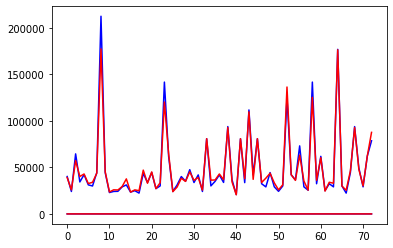

In [33]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5, weights='uniform', 
                            algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
# defining parameter range 
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 9, 10, 13, 15],  
             'weights' : ['uniform', 'distance'],
              'p' : [1, 2, 4, 5, 7 ,10]
             } 
grid = GridSearchCV(neigh, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))

# 6. Decision Tree + Grid Search

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 1512 candidates, totalling 4536 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.917, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.872, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.753, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.723, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.830, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.857, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.739, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.672, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.677, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.689, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.734, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.888, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.689, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.723, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.864, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.852, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.600, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.852, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.788, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.739, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.496, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.744, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.789, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.786, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.523, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.389, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.510, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.657, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.637, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.138, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.187, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.405, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.781, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.773, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.676, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.643, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.405, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.805, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.580, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.653, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.579, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.734, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.623, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.744, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.610, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.469, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.846, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.864, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.629, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.531, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.405, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.786, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.684, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.669, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.500, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.652, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.086, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.857, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.565, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.736, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.406, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.728, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.800, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.788, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.742, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.637, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.519, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.606, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.420, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.684, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.845, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.672, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.749, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.246, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.503, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.822, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.628, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.592, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.103, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.807, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.635, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.588, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.623, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.985, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.972, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.764, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.968, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.972, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.970, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.733, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.853, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.975, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.970, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.949, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.975, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.864, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.913, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.960, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.665, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.777, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.936, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.885, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.679, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.750, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.867, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.545, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.738, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.608, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.591, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.707, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.532, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.708, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.796, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.585, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.770, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.521, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.822, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.852, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.623, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.718, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.620, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.815, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.878, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.714, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.566, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.796, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.855, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.329, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.614, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.846, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.858, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.757, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.894, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.655, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.788, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.871, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.673, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.830, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.612, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.585, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.879, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.720, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.878, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.769, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.850, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.764, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.750, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.623, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.637, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.818, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.728, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.654, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.786, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.565, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.812, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.744, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.818, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.712, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.993, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.968, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.962, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.977, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.993, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.962, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.912, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.800, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.987, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.985, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.967, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.967, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.983, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.967, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.878, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.896, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.954, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.943, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.717, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.936, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.962, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.885, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.708, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.962, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.772, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.873, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.730, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.753, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.845, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.871, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.765, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.899, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.887, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.765, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.968, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.878, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.888, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.837, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.783, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.965, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.687, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.612, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.592, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.857, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.785, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.626, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.705, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.621, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.711, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.903, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.941, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.911, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.859, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.781, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.851, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.769, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.858, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.841, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.922, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.775, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.856, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.887, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.731, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.864, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.861, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.925, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.805, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.877, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.609, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.846, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.777, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.783, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.976, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.992, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.902, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.957, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.978, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.719, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.828, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.823, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.704, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.806, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.865, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.905, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.922, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.771, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.899, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.730, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.781, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.814, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.893, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.943, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.850, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.738, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.862, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.833, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.877, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.694, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.652, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.593, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.905, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.807, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.613, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.605, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.823, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.912, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.415, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.954, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.912, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.951, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.806, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.888, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.766, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.820, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.940, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.848, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.842, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.728, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.809, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.968, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.906, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.785, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.769, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.586, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.619, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.907, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.749, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.670, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.788, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.620, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.716, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.826, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.796, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.751, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.623, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.994, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.973, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.978, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.736, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.763, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.917, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.871, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.777, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.895, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.716, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.961, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.921, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.961, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.932, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.949, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.634, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.869, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.794, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.915, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.631, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.903, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.883, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.911, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.922, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.883, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.664, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.859, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.880, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.689, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.681, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.683, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.794, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.691, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.886, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.724, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.743, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.394, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.794, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.858, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.753, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.862, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.619, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.936, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.959, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.918, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.918, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.949, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.557, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.865, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.569, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.913, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.826, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.895, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.695, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.806, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.903, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.706, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.761, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.622, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.757, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.960, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.865, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.573, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.687, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.840, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.809, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.925, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.751, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.766, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.622, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.774, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.755, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.707, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.638, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.641, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.994, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.911, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.992, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.606, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.794, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.675, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.894, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.809, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.856, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.811, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.951, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.947, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.893, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.957, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.952, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.810, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.927, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.820, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.906, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.869, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.762, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.924, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.665, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.818, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.912, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.903, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.706, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.809, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.777, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.868, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.826, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.899, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.404, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.651, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.830, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.601, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.641, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.903, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.941, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.614, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.808, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.939, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.941, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.804, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.896, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.528, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.830, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.780, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.934, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.893, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.638, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.468, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.605, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.875, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.880, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.848, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.933, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.870, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.781, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.755, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.661, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.645, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.812, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.944, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.864, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.925, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.736, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.905, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.874, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.882, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.927, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.970, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.952, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.987, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.955, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.985, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.836, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.856, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.947, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.931, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.938, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.861, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.811, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.831, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.918, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.710, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.688, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.062, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.907, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.808, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.636, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.656, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.808, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.833, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.772, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.741, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.894, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.906, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.899, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.837, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.592, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.936, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.954, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.947, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.858, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.757, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.796, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.646, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.836, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.960, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.836, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.687, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.762, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.922, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.749, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.629, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.875, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.743, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.753, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.864, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.785, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.629, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.875, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.854, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.761, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.662, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.654, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.991, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.973, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.845, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.957, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.761, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.839, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.931, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.908, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.954, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.968, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.949, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.850, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.957, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.886, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.946, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.943, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.716, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.947, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.823, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.957, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.660, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.718, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.776, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.810, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.811, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.943, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.766, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.820, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.760, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.621, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.859, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.692, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.803, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.653, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.163, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.776, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.809, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.646, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.763, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.865, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.968, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.939, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.983, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.976, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.949, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.953, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.883, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.965, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.936, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.822, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.839, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.692, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.831, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.918, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.883, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.831, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.774, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.637, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.883, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.741, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.631, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.836, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.949, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.905, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.975, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.982, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.960, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.837, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.939, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.789, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.909, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.905, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.943, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.750, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.967, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.974, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.961, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.977, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.842, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.810, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.902, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.556, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.954, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.695, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.742, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.840, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.707, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.891, total=   0.1s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.887, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.764, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.820, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.944, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.900, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.908, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.893, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.873, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.781, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.629, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.659, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.903, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.913, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.751, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.645, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.987, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.942, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.927, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.940, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.943, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.829, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.906, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.961, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.820, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.938, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.812, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.940, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.818, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.868, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.907, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.637, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.878, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.816, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.824, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.868, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.928, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.735, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.775, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.676, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.668, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.875, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.841, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.718, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.822, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.744, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.985, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.881, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.975, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.796, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.815, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.893, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.949, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.757, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.907, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.731, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.736, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.828, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.931, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.953, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.466, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.938, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.941, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.927, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.897, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.609, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.918, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.970, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.929, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.905, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.953, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.980, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.689, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.755, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.915, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.736, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.691, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.886, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.895, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.897, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.842, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.717, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.931, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.965, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.719, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.656, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.664, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.790, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.765, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.906, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.800, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.711, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.951, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.900, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.951, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.982, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.953, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.827, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.771, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.960, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.931, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.828, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.820, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.934, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.967, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.922, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.648, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.611, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.880, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.896, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.788, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.814, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.659, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.815, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.828, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.941, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.714, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.785, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.733, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.707, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.631, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.933, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.992, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.607, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.792, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.960, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.678, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.952, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.959, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.965, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.902, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.884, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.908, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.786, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.944, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.879, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.983, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.854, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.968, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.880, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.826, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.856, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.838, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.837, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.731, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.750, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.809, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.932, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.842, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.615, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.883, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.780, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.582, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.692, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.769, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.611, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.633, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.812, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.894, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.744, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.663, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.676, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.419, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.947, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.934, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.926, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.841, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.965, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.577, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.777, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.977, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.803, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.879, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.904, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.668, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.826, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.834, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.578, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.702, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.806, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.868, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.616, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.662, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.878, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.685, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.970, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.980, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.978, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.973, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.913, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.943, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.901, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.896, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.887, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.889, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.954, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.896, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.871, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.993, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.971, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.965, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.804, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.916, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.946, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.838, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.806, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.859, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.806, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.727, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.667, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.591, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.613, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.831, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.804, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.940, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.869, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.769, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.742, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.893, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.804, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.713, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.628, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.826, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.992, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.959, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.931, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.953, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.945, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.935, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.913, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.812, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.940, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.741, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.800, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.810, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.896, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.902, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.920, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.715, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.837, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.789, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.634, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.893, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.613, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.665, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.917, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.910, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.688, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.857, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.740, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.917, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.910, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.878, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.876, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.917, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.910, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.722, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.793, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.740, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.917, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.654, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.878, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.761, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.784, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.889, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.648, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.889, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.727, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.761, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.637, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.735, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.104, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.632, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.766, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.768, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.658, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.729, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.495, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.658, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.791, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.610, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.673, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.820, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.657, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.708, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.521, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.086, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.405, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.606, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.758, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.845, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.794, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.747, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.257, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.842, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.569, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.552, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.786, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.794, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.578, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.757, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.569, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.746, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.553, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.316, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.725, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.800, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.729, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.590, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.708, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.678, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.744, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.634, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.752, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.600, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.610, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.729, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.626, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.642, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.735, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.603, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.679, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.469, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.574, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.558, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.728, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.138, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.810, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.790, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.758, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.614, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.080, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.711, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.606, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.661, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.746, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.663, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.543, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.575, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.338, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.985, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.981, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.915, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.925, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.968, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.970, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.885, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.975, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.966, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.970, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.748, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.856, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.899, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.975, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.966, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.848, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.966, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.779, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.689, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.807, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.936, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.727, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.789, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.701, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.859, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.855, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.847, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.624, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.883, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.817, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.808, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.831, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.650, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.837, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.664, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.491, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.614, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.728, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.871, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.742, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.809, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.821, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.822, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.629, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.738, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.625, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.664, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.830, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.715, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.826, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.862, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.651, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.701, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.824, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.689, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.497, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.731, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.783, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.852, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.912, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.742, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.647, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.885, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.742, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.820, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.796, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.782, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.553, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.826, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.750, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.642, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.832, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.783, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.740, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.680, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.770, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.687, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.500, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.866, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.634, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.781, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.854, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.829, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.725, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.598, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.818, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.887, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.830, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.819, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.726, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.496, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.993, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.977, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.907, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.914, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.977, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.993, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.900, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.941, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.974, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.987, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.985, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.699, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.927, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.858, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.983, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.967, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.908, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.961, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.803, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.954, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.802, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.884, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.936, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.962, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.789, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.885, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.830, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.962, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.826, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.932, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.771, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.710, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.656, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.797, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.791, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.831, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.803, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.775, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.861, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.735, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.839, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.796, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.771, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.857, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.728, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.889, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.896, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.578, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.595, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.650, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.716, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.903, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.818, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.784, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.850, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.794, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.634, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.714, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.784, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.766, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.902, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.893, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.351, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.897, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.883, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.885, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.696, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.875, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.806, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.617, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.800, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.928, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.731, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.751, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.763, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.867, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.933, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.958, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.648, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.761, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.862, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.896, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.554, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.855, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.609, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.925, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.867, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.548, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.772, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.808, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.887, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.903, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.823, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.704, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.915, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.758, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.803, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.700, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.715, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.744, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.978, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.980, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.940, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.729, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.962, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.942, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.929, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.839, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.667, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.822, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.790, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.784, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.811, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.693, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.970, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.808, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.926, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.940, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.884, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.595, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.931, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.775, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.629, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.883, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.911, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.900, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.656, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.834, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.789, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.861, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.805, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.892, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.928, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.823, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.580, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.539, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.829, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.916, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.727, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.870, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.860, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.770, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.748, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.689, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.660, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.636, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.951, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.839, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.763, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.931, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.605, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.939, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.760, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.817, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.888, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.932, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.897, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.767, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.867, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.752, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.675, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.793, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.640, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.681, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.833, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.820, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.877, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.862, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.599, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.720, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.866, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.801, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.870, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.002, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.786, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.791, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.983, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.987, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.983, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.760, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.958, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.900, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.945, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.954, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.888, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.794, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.824, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.907, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.740, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.838, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.797, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.965, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.908, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.932, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.935, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.943, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.853, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.976, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.951, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.742, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.884, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.793, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.884, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.861, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.704, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.932, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.797, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.911, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.841, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.837, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.746, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.802, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.820, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.818, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.894, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.661, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.736, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.640, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.743, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.861, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.636, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.909, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.980, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.840, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.934, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.925, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.809, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.926, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.952, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.801, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.919, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.810, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.836, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.900, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.847, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.866, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.875, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.907, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.715, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.720, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.823, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.929, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.907, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.695, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.744, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.831, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.663, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.715, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.614, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.626, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.777, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.768, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.659, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.757, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.614, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.993, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.927, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.841, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.884, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.869, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.950, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.744, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.790, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.876, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.922, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.932, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.902, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.768, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.609, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.944, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.967, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.941, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.802, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.965, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.603, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.824, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.936, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.855, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.851, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.929, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.796, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.716, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.866, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.777, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.869, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.866, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.630, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.935, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.730, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.646, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.781, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.692, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.757, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.702, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.858, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.793, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.703, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.723, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.908, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.834, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.851, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.835, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.786, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.865, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.793, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.748, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.939, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.911, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.886, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.924, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.702, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.575, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.915, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.885, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.721, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.871, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.671, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.716, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.945, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.738, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.740, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.643, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.814, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.835, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.902, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.647, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.770, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.929, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.994, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.975, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.981, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.676, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.838, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.934, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.950, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.928, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.821, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.899, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.834, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.820, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.858, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.694, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.910, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.915, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.851, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.853, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.928, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.862, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.845, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.927, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.806, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.808, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.953, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.920, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.900, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.848, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.571, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.794, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.804, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.650, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.896, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.900, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.770, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.848, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.405, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.873, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.859, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.819, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.730, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.483, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.822, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.942, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.909, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.919, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.950, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.858, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.903, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.957, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.763, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.927, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.911, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.939, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.817, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.873, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.636, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.843, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.938, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.857, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.647, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.606, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.661, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.909, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.583, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.719, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.597, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.836, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.851, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.604, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.633, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.845, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.653, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.970, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.974, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.837, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.767, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.912, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.958, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.913, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.899, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.723, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.970, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.794, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.837, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.877, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.856, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.947, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.977, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.941, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.974, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.854, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.939, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.926, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.838, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.775, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.944, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.679, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.862, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.786, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.890, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.921, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.761, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.819, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.835, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.596, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.884, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.687, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.413, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.836, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.915, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.656, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.786, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.265, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.802, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.897, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.826, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.857, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.771, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.913, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.893, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.934, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.903, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.965, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.931, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.934, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.910, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.919, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.886, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.817, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.797, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.913, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.766, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.911, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.772, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.943, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.650, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.621, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.825, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.883, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.871, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.749, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.874, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.670, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.790, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.910, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.873, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.617, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.060, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.834, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.952, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.973, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.837, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.918, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.835, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.987, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.981, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.918, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.916, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.939, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.933, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.833, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.935, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.818, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.952, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.791, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.962, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.841, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.744, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.957, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.913, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.776, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.918, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.909, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.653, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.783, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.940, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.731, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.725, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.760, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.852, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.697, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.859, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.876, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.908, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.789, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.641, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.813, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.433, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.957, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.916, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.981, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.944, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.983, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.878, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.822, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.879, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.914, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.853, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.942, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.944, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.970, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.767, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.879, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.887, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.846, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.782, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.776, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.874, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.875, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.804, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.763, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.628, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.899, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.752, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.685, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.727, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.871, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.836, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.829, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.815, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.763, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.642, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.970, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.848, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.933, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.968, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.815, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.958, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.922, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.782, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.783, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.909, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.915, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.938, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.965, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.965, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.965, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.843, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.983, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.799, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.818, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.943, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.566, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.839, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.957, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.703, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.672, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.887, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.694, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.857, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.826, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.717, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.922, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.897, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.825, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.874, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.660, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.876, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.779, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.826, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.921, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.875, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.765, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.813, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.659, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.682, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.696, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.875, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.978, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.973, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.965, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.944, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.947, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.980, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.910, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.938, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.768, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.879, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.936, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.921, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.856, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.818, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.916, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.917, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.746, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.938, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.900, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.859, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.835, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.867, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.917, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.767, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.675, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.802, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.896, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.846, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.644, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.729, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.821, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.883, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.745, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.919, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.755, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.834, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.973, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.993, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.981, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.840, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.958, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.942, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.920, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.803, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.735, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.810, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.874, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.918, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.892, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.902, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.675, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.939, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.987, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.962, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.931, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.896, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.919, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.944, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.886, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.945, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.743, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.961, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.670, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.760, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.846, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.898, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.796, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.889, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.656, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.830, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.769, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.760, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.919, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.773, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.664, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.758, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.653, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.911, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.813, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.030, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.888, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.732, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.839, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.945, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.957, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.847, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.974, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.957, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.883, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.841, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.779, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.934, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.918, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.808, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.807, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.888, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.934, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.794, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.922, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.819, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.776, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.919, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.644, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.931, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.689, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.869, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.810, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.772, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.819, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.797, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.912, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.533, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.842, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.702, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.806, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.902, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.872, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.804, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.610, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.647, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.950, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.851, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.939, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.786, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.956, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.964, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.803, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.888, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.890, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.937, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.907, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.871, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.793, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.948, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.904, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.871, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.757, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.985, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.974, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.981, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.909, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.516, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.946, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.903, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.886, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.878, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.846, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.955, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.713, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.874, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.884, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.624, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.840, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.908, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.932, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.913, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.875, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.691, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.806, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.850, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.225, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.824, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.907, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.748, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.639, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.760, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.631, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.837, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.941, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.623, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.654, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.930, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.987, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.966, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.961, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.916, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.649, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.908, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.943, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.879, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.599, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.936, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.895, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.892, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.622, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.870, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.928, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.905, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.915, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.881, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.897, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.714, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.553, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.543, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.865, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.851, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.912, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.644, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.875, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.805, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.883, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.859, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.832, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.636, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.768, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.865, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.806, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.906, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.660, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.822, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.613, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.657, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.868, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.663, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.838, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.764, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.684, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.758, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.676, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.693, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.849, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.735, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.869, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.776, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.869, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.824, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.883, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.773, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.739, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.852, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.555, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.662, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.368, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.748, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.677, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.582, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.580, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.830, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.702, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.657, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.412, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.830, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.814, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.420, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.665, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.111, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.071, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.760, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.815, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.772, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.733, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.646, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.788, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.561, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.756, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.599, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.636, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.769, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.726, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.774, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.096, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.674, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.772, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.518, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.084, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.605, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.722, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.787, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.593, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.480, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.776, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.809, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.701, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.489, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.744, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.595, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.494, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.826, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.537, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.421, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.812, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.669, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.829, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.772, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.594, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.060, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.788, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.693, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.719, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.390, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.983, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.864, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.908, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.739, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.858, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.957, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.675, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.966, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.923, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.878, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.880, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.751, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.743, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.962, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.939, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.738, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.924, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.918, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.867, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.777, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.755, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.802, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.788, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.756, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.763, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.607, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.836, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.638, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.844, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.577, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.694, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.895, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.772, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.765, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.581, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.708, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.419, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.589, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.864, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.747, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.761, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.825, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.815, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.587, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.481, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.854, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.839, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.842, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.287, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.739, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.805, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.812, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.605, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.670, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.852, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.724, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.683, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.906, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.872, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.788, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.758, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.736, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.552, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.577, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.580, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.735, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.838, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.595, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.741, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.224, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.615, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.765, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.813, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.869, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.894, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.819, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.644, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.837, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.442, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.998, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.938, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.980, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.975, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.956, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.944, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.949, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.943, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.628, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.972, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.933, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.870, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.932, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.836, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.954, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.773, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.810, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.877, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.933, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.879, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.928, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.919, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.734, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.888, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.839, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.658, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.805, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.573, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.733, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.931, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.862, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.728, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.830, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.726, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.865, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.805, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.647, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.675, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.740, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.818, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.823, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.742, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.540, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.559, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.656, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.841, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.879, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.577, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.480, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.581, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.849, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.765, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.472, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.698, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.703, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.834, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.816, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.826, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.588, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.818, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.909, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.843, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.557, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.747, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.663, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.714, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.861, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.839, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.856, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.572, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.739, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.841, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.544, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.844, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.887, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.622, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.761, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.607, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.736, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.846, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.681, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.540, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.743, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.641, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.820, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.977, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.984, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.995, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.960, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.980, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.618, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.940, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.941, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.934, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.954, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.963, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.721, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.901, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.934, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.752, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.844, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.928, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.878, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.886, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.865, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.938, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.907, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.839, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.915, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.922, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.857, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.644, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.857, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.834, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.808, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.677, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.861, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.617, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.846, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.632, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.881, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.809, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.694, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.601, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.863, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.632, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.670, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.893, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.680, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.811, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.911, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.960, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.808, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.818, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.822, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.835, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.466, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.876, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.586, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.849, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.953, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.865, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.824, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.871, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.878, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.564, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.867, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.771, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.762, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.593, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.813, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.937, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.899, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.838, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.824, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.776, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.879, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.611, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.822, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.433, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.854, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.726, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.825, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.861, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.572, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.686, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.991, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.805, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.988, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=2, splitter=random, score=0.977, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.974, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=3, splitter=random, score=0.550, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.773, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.967, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=4, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.901, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=5, splitter=random, score=0.910, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=6, splitter=random, score=0.918, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.906, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.764, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=auto, min_samples_leaf=7, splitter=random, score=0.661, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.908, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.909, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.918, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.754, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.863, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.757, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.880, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.785, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.909, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.747, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.861, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.609, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.718, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.670, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.494, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.882, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.865, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.756, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.610, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.505, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.836, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.615, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.823, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.726, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.785, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.592, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.728, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.641, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.857, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.766, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=1, splitter=random, score=0.925, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.865, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.959, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=2, splitter=random, score=0.744, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.930, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.516, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.894, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=3, splitter=random, score=0.701, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.783, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.936, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=best, score=0.896, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.886, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=4, splitter=random, score=0.710, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.683, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.870, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=5, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.800, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.808, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.676, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.610, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=6, splitter=random, score=0.883, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=best, score=0.812, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.834, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.888, total=   0.0s
[CV] criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, max_features=log2, min_samples_leaf=7, splitter=random, score=0.761, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.977, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.893, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.969, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.880, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.961, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.904, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.828, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.938, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.742, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.802, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.773, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.794, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.760, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.886, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.962, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.889, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.917, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.806, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.734, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.794, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.856, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.838, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.916, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.856, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.889, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.853, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.823, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.914, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.821, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.836, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.741, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.943, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.835, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.764, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.661, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.883, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.892, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.845, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.595, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.424, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.682, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.867, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.728, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.923, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.970, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.898, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.635, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.909, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.959, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.836, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.757, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.858, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.913, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.734, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.907, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.896, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.785, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.812, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.739, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.656, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.888, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.902, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.690, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.642, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.663, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.828, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.867, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.854, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.727, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.743, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.845, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.886, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.810, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.774, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.764, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.788, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.646, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.957, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.984, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=2, splitter=random, score=0.687, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.909, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=3, splitter=random, score=0.956, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.966, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=4, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.756, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, splitter=random, score=0.738, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.809, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=6, splitter=random, score=0.805, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.677, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=7, splitter=random, score=0.766, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.883, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.750, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.947, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.710, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.894, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.830, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.931, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.925, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.919, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.563, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.589, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.683, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.899, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.868, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.689, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.924, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.696, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.821, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.947, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.897, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.220, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.703, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.686, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.655, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.837, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.775, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.723, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.907, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.585, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.584, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.922, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.864, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.598, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.857, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.426, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.954, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.916, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=best, score=0.995, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.968, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=1, splitter=random, score=0.905, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.914, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=best, score=0.951, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.931, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=2, splitter=random, score=0.792, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.943, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=best, score=0.838, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.785, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.908, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=3, splitter=random, score=0.615, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.871, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.883, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=best, score=0.752, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.699, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.736, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=4, splitter=random, score=0.658, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.878, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.942, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=best, score=0.879, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.700, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=5, splitter=random, score=0.756, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.845, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=best, score=0.881, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.655, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=6, splitter=random, score=0.587, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.886, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=best, score=0.787, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.692, total=   0.0s
[CV] criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, max_features=log2, min_samples_leaf=7, splitter=random, score=0.599, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.998, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.985, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.986, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.634, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.968, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.968, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.728, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.680, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.868, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.754, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.992, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.944, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.947, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.932, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.904, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.939, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.963, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.871, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.830, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.903, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.821, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.722, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.628, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.913, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.881, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.837, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.936, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.763, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.806, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.940, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.690, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.407, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.749, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.654, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.810, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.650, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.791, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.618, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.590, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.987, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.965, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.937, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.939, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.410, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.934, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.971, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.822, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.828, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.836, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.747, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.925, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.757, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.862, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.785, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.883, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.621, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.864, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.913, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.895, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.823, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.882, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.890, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.603, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.949, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.851, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.728, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.857, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.877, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.555, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.423, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.804, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.791, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.800, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.914, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.707, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.873, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.792, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.766, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.943, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.972, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.794, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.922, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.769, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.781, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.809, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.811, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.990, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.975, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.776, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.970, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.961, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.783, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.912, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.543, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.910, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.867, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.718, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.726, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.867, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.948, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.789, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.924, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.732, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.902, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.708, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.712, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.777, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.816, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.894, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.612, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.656, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.664, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.712, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.680, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.537, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.433, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.972, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.912, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.901, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.831, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.950, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.890, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.771, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.947, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.667, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.943, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.608, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.897, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.780, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.603, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.830, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.917, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.806, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.733, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.899, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.859, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.095, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.709, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.816, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.880, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.864, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.708, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.928, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.856, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.641, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.586, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.658, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.998, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.995, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.944, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.871, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.969, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.651, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.757, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.951, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.911, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.710, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.885, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.941, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.805, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.781, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.820, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.986, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.889, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.967, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.983, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.949, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.876, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.717, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.840, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.958, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.891, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.950, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.816, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.899, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.884, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.917, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.511, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.819, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.700, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.886, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.662, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.696, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.962, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.781, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.873, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.845, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.712, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.894, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.585, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.594, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.835, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.885, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.865, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.448, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.592, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.909, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.447, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.984, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.952, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.558, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.945, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.936, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.845, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.942, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.590, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.912, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.743, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.734, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.854, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.933, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.901, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.862, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.900, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.450, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.809, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.792, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.771, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.879, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.925, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.506, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.624, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.796, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.431, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.819, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.781, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.860, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.813, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.687, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.860, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.960, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.966, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.969, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.930, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.670, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.880, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.902, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.681, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.969, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.841, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.923, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.939, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.596, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.862, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.848, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.893, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.512, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.783, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.900, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.719, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.956, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.888, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.933, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.634, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.857, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.701, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.584, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.724, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.837, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.855, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.633, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.753, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.814, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.688, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.863, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.839, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.765, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.832, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.835, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.903, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.996, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.868, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.916, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.757, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.916, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.943, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.907, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.933, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.855, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.735, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.766, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.733, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.941, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.853, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.755, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.712, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.933, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.650, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.650, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.923, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.838, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.583, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.625, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.589, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.575, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.822, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.837, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.654, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=0.999, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=1.000, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.997, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.864, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.992, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.981, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.976, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.967, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.765, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.973, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.979, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.745, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.948, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.825, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.955, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.978, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.927, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.719, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.964, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.786, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.888, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.839, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.921, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.926, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.894, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.919, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.946, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.911, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.994, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.971, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.957, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.929, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.982, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.831, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.734, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.601, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.508, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.919, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.947, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.943, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.647, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.916, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.892, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.856, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.396, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.697, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.703, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.638, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.744, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.896, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.895, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.498, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.667, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.877, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.749, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.750, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.754, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.736, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.920, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.813, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.649, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.609, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.988, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.891, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.989, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.922, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.983, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.968, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.898, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.974, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.939, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.742, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.915, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.460, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.845, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.894, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.856, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.739, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.892, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.835, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.815, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.917, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.686, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.909, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.766, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.880, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.844, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.869, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.659, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.717, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.763, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.863, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.935, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.789, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.632, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.622, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.668, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.738, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.448, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.880, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.789, total=   0.0s


[Parallel(n_jobs=1)]: Done 4536 out of 4536 | elapsed:   50.5s finished
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'mae', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'splitter': 'best'}
DecisionTreeRegressor(criterion='mae', max_depth=9, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
MSE =  22.115357863931422
R2 score = 0.9957954489371483

Mean Absolute Percentage Error = [5.07948326e-05 1.24541785e-02]


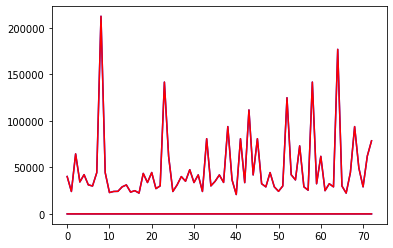

In [50]:
from sklearn.tree import DecisionTreeRegressor #  ' min_samples_split' : [2],
regressor = DecisionTreeRegressor()
# defining parameter range 
param_grid = {'criterion': ['mse','friedman_mse', 'mae'],  
              'splitter' : ['best', 'random'], 
              'max_depth': [2,3,4,5,6,7,8,9,10,15,20,30 ],
              'min_samples_leaf' : [1, 2,3,4,5,6,7],
              'max_features' : ['auto', 'sqrt', 'log2'],
             } 
grid = GridSearchCV(regressor, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))

# 7. Random Forest + Grid Search

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.985, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.987, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.983, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.972, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.984, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.974, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.971, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.986, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.986, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.986, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.985, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.981, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.987, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.989, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.983, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.985, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.988, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.979, total=   0.4s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.987, total=   0.4s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.988, total=   0.4s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.979, total=   0.5s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.986, total=   0.4s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.988, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.982, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.994, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.991, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.986, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.982, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.996, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.997, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.985, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.997, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.997, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.989, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.996, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.997, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.989, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.996, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.996, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.993, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.976, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.989, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.983, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.997, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.991, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.986, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.998, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.993, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=True, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=True, score=0.991, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=False, score=0.969, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=False, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=True, score=0.989, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=False, score=0.988, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=True, score=0.990, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=False, score=0.988, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=True, score=0.992, total=   0.4s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=True, score=0.998, total=   0.3s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.988, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.992, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.992, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.990, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.993, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.988, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.986, total=   0.4s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.984, total=   0.4s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=True, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=False, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=True, score=0.987, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=False, score=0.992, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=True, score=0.988, total=   0.3s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=False, score=0.984, total=   0.2s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=True, score=0.992, total=   0.4s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=False, score=0.999, total=   0.5s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=True, score=0.979, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=False, score=0.987, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=False, score=0.987, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=True, score=0.987, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=False, score=0.989, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=True, score=0.988, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=False, score=0.984, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=True, score=0.988, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=False, score=0.989, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.989, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.981, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.986, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.990, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.987, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.990, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=False, score=0.975, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=True, score=0.988, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=True, score=0.994, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=False, score=0.988, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=True, score=0.990, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=False, score=0.987, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=False, score=0.996, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=True, score=0.987, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=False, score=0.991, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=True, score=0.993, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=False, score=0.975, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=False, score=0.994, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=True, score=0.988, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=False, score=0.988, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=True, score=0.988, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=False, score=0.986, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=False, score=0.998, total=   0.3s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=True, score=0.989, total=   0.5s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=False, score=0.986, total=   0.4s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.972, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.994, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.989, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.987, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.989, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.998, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.990, total=   0.5s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.999, total=   0.5s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.981, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.966, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.992, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.986, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.993, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.998, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.989, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.990, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.989, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.983, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.973, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.980, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.980, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.985, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.989, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.986, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.981, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.987, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.988, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.977, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.987, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.987, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.979, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.987, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.987, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.981, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.986, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.988, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.976, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.993, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.985, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.977, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.993, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.987, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.982, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.991, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.996, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.995, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.984, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.996, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.987, total=   0.5s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.996, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.997, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.988, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.996, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.996, total=   0.5s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.974, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.989, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.989, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.989, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.985, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.990, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.997, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.988, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.997, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.998, total=   0.3s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True, score=0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False, score=0.986, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False, score=0.992, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True, score=0.988, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False, score=0.991, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True, score=0.989, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False, score=0.986, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True, score=0.987, total=   0.4s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False, score=0.990, total=   0.3s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.984, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.988, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.990, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.989, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.997, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.985, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True, score=0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True, score=0.988, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True, score=0.988, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False, score=0.989, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True, score=0.987, total=   0.4s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False, score=0.982, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True, score=0.974, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False, score=0.984, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True, score=0.989, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False, score=0.988, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True, score=0.991, total=   0.4s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False, score=0.984, total=   0.4s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False, score=0.997, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.973, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.991, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.993, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.992, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.988, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.987, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.987, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True, score=0.969, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True, score=0.991, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False, score=0.992, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True, score=0.991, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True, score=0.997, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False, score=0.990, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True, score=0.990, total=   0.4s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True, score=0.940, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True, score=0.981, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False, score=0.992, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True, score=0.988, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False, score=0.987, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True, score=0.993, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False, score=0.991, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.981, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.983, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.994, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.990, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.991, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.991, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.985, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.989, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.985, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.982, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.988, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.994, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.989, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.987, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.991, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.985, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.997, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.989, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.951, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.983, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.982, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.961, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.981, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.982, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.960, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.983, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.987, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.970, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.980, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.983, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.962, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.981, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.980, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.966, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.983, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.986, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.966, total=   1.0s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.983, total=   1.0s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.983, total=   1.0s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.961, total=   1.0s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.983, total=   1.0s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.984, total=   1.0s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.969, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.993, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.990, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.977, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.995, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.996, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.984, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.994, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.994, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.976, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.994, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.995, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.978, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.995, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.997, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.984, total=   1.2s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.995, total=   1.2s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.996, total=   1.2s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.985, total=   1.2s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.995, total=   1.2s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.996, total=   1.2s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.976, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.987, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.990, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.983, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.997, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.993, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.986, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.994, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.987, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.998, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.998, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.989, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.997, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.998, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.983, total=   1.3s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.998, total=   1.4s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.997, total=   1.3s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.988, total=   1.3s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.998, total=   1.3s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.998, total=   1.3s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=True, score=0.979, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=False, score=0.972, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=False, score=0.988, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=True, score=0.986, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=True, score=0.996, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=False, score=0.986, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=True, score=0.987, total=   0.7s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=True, score=0.998, total=   0.7s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=True, score=0.997, total=   0.7s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=False, score=0.986, total=   0.8s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=False, score=0.998, total=   0.7s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=False, score=0.997, total=   0.7s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=True, score=0.985, total=   1.4s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=True, score=0.998, total=   1.5s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=True, score=0.998, total=   1.4s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=False, score=0.985, total=   1.5s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=False, score=0.998, total=   1.5s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.988, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.989, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.989, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.988, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.985, total=   1.1s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.998, total=   1.0s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.987, total=   1.2s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.999, total=   1.0s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.998, total=   1.1s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.986, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.998, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.998, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.988, total=   1.9s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.999, total=   1.5s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.998, total=   1.5s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=True, score=0.992, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=False, score=0.979, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=True, score=0.988, total=   0.4s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=False, score=0.987, total=   0.4s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=True, score=0.988, total=   0.8s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=True, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=False, score=0.986, total=   0.8s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=False, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=False, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=True, score=0.986, total=   1.6s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=True, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=True, score=0.998, total=   1.5s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=False, score=0.984, total=   1.6s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=False, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=False, score=0.998, total=   1.5s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=True, score=0.991, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=False, score=0.994, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=False, score=0.992, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=True, score=0.987, total=   0.4s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=True, score=0.990, total=   0.4s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=False, score=0.987, total=   0.4s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=True, score=0.986, total=   0.8s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=False, score=0.990, total=   0.8s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=False, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=False, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=True, score=0.989, total=   1.6s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=True, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=False, score=0.986, total=   1.6s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=False, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=False, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.991, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.952, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.984, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.996, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.972, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.988, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.983, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.997, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.988, total=   1.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.986, total=   2.5s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.999, total=   1.7s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=True, score=0.982, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=False, score=0.977, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=False, score=0.990, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=False, score=0.993, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=True, score=0.984, total=   0.4s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=True, score=0.997, total=   0.4s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=False, score=0.980, total=   0.4s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=False, score=0.996, total=   0.4s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=True, score=0.989, total=   0.8s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=True, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=False, score=0.990, total=   0.8s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=False, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=False, score=0.996, total=   0.8s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=True, score=0.988, total=   1.6s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=True, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=False, score=0.984, total=   1.6s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=False, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=False, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=True, score=0.972, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=False, score=0.992, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=False, score=0.992, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=True, score=0.978, total=   0.4s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=False, score=0.990, total=   0.4s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=False, score=0.997, total=   0.4s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=True, score=0.989, total=   0.8s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=True, score=0.997, total=   0.8s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=True, score=0.997, total=   0.8s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=False, score=0.991, total=   0.8s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=False, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=False, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=True, score=0.990, total=   1.6s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=False, score=0.989, total=   1.7s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=False, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=False, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.988, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.993, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.977, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.989, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.997, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.993, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.997, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.983, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.997, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.989, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.997, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.988, total=   1.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.998, total=   1.8s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.988, total=   1.9s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.999, total=   1.8s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.998, total=   1.8s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.987, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.994, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.978, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.991, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.981, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.988, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.979, total=   0.9s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.986, total=   0.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.986, total=   1.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.981, total=   1.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.998, total=   1.6s


[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:  5.1min finished
0it [00:00, ?it/s]


{'criterion': 'friedman_mse', 'max_depth': 9, 'n_estimators': 10, 'warm_start': 'True'}
RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start='True')
MSE =  8500395.834815368
R2 score = 0.9856373464322283

Mean Absolute Percentage Error = [0.03903226 0.09760647]


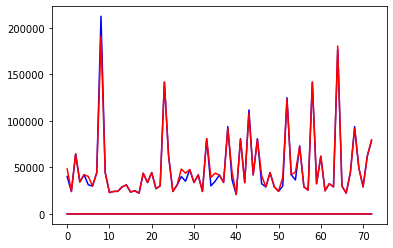

In [52]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                            max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                            bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                            verbose=0, warm_start=False)
# defining parameter range 
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,6,7,8,9,10,11,13,15, None ],
              'warm_start': ['True', 'False'],

             } 

grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
tqdm(grid.fit(X_train, Y_train)) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))

# 8. Extrememly Randomized Trees + Grid Search

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.950, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.944, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.959, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.931, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.944, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.956, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.929, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.954, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.949, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.928, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.949, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.953, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.931, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.949, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.955, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.925, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.945, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.951, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.939, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.952, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.950, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.928, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.950, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.947, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.977, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.986, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.985, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.983, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.985, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.989, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.979, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.983, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.987, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.986, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.985, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.990, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.983, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.987, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.988, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.986, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.984, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.988, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.984, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.984, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.990, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.993, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.997, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.990, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.994, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.994, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.997, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.997, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.997, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.998, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.996, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.997, total=   0.3s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=50, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   0.6s
[CV] criterion=mse, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   0.6s
[CV] criterion=mse, max_depth=12, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=12, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=12, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=12, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=12, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=12, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=12, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=12, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=12, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=12, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=50, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=12, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=12, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=12, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=12, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=12, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=12, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=12, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=12, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=12, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=12, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=12, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=12, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=12, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=12, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=12, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=14, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=14, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=14, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=14, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=14, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=14, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=14, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=14, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=14, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=14, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=14, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=mse, max_depth=14, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=14, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=14, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=14, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=14, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=14, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=16, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=16, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=16, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=16, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=16, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=16, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=16, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=16, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=16, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=16, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=16, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=16, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=50, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mse, max_depth=16, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=16, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=16, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=16, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=16, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=16, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=16, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mse, max_depth=16, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mse, max_depth=16, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=16, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mse, max_depth=16, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mse, max_depth=16, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mse, max_depth=17, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=17, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=17, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=10, warm_start=True, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=17, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=mse, max_depth=17, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=17, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=10, warm_start=False, score=0.995, total=   0.0s
[CV] criterion=mse, max_depth=17, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=17, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=17, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=17, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=17, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=17, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=17, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=17, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=17, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=17, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=17, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=17, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=17, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=17, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=17, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=17, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=17, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=17, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.996, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.893, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.936, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.936, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.885, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.945, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.918, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.949, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.949, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.921, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.943, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.951, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.936, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.953, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.959, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.934, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.952, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.956, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.928, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.950, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.955, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.930, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.957, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.949, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.979, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.980, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.990, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.992, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.977, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.987, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.983, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.982, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.990, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.980, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.983, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.982, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.984, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.990, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.983, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.985, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.988, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.986, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.984, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.988, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.986, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.986, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.989, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.994, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.991, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.992, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.997, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.997, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.998, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.996, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.997, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.996, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.997, total=   0.3s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False, score=0.998, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=True, score=0.996, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=10, warm_start=False, score=0.995, total=   0.0s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=True, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=True, score=0.998, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=13, n_estimators=200, warm_start=False, score=0.999, total=   0.3s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.999, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.999, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.895, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.956, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.918, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.926, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.961, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.904, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.925, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.962, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.949, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.911, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.946, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.927, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.892, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.957, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.935, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.895, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.951, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.925, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.903, total=   1.1s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.957, total=   1.1s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.932, total=   1.2s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.897, total=   1.2s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.954, total=   1.1s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.933, total=   1.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.953, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.977, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.971, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.933, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.967, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.973, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.973, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.982, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.979, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.974, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.981, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.980, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.969, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.983, total=   0.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.979, total=   0.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.969, total=   0.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.980, total=   0.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.983, total=   0.7s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.964, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.979, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.979, total=   1.3s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.970, total=   1.3s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.981, total=   1.3s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.981, total=   1.3s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.990, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.987, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.969, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.994, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.995, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.994, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.993, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.995, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.995, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.995, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.993, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.994, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.995, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.993, total=   0.8s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.995, total=   0.9s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.992, total=   1.8s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.993, total=   1.7s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.996, total=   1.7s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.992, total=   1.6s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.993, total=   1.4s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.994, total=   1.5s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=True, score=0.997, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=False, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=10, warm_start=False, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=True, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=True, score=0.996, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=False, score=0.998, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=True, score=0.998, total=   0.8s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=True, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.8s
[CV] criterion=mae, max_depth=6, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=100, warm_start=False, score=0.999, total=   0.9s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=True, score=0.998, total=   1.7s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=True, score=0.999, total=   1.6s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=False, score=0.998, total=   1.6s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   1.7s
[CV] criterion=mae, max_depth=6, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=6, n_estimators=200, warm_start=False, score=0.999, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.998, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=1.000, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.999, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.999, total=   0.9s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.8s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=1.000, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=1.000, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=1.000, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.999, total=   1.7s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=8, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=50, warm_start=False, score=0.998, total=   0.5s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=8, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   1.8s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=True, score=1.000, total=   1.8s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=True, score=0.999, total=   1.8s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   1.8s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=8, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=8, n_estimators=200, warm_start=False, score=0.999, total=   2.2s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=True, score=0.996, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=10, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=10, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=True ....


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=True, score=0.998, total=   0.6s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=9, n_estimators=50, warm_start=False ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=9, n_estimators=100, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=100, warm_start=False, score=0.998, total=   1.1s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   2.1s
[CV] criterion=mae, max_depth=9, n_estimators=200, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, n_estimators=200, warm_start=False, score=1.000, total=   2.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.997, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   1.3s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.999, total=   1.1s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=1.000, total=   2.8s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.999, total=   2.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   2.4s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=1.000, total=   2.1s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.999, total=   2.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.6s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=11, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=50, warm_start=False, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=11, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=True, score=0.999, total=   2.0s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=11, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=11, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=12, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=12, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=12, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=12, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=12, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=12, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=12, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=12, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=12, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=50, warm_start=True, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=12, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=12, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=12, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=50, warm_start=False, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=12, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=12, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=12, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=12, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=12, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=12, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=12, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=12, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=12, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=12, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=12, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=12, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=12, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=13, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=13, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=True, score=1.000, total=   2.8s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=13, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=13, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=14, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=14, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=14, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=14, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=14, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=10, warm_start=False, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=14, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=14, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=14, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=14, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=50, warm_start=True, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=14, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=14, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=14, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=14, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=14, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=14, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=14, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=100, warm_start=False, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=14, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=14, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=100, warm_start=False, score=0.998, total=   1.0s
[CV] criterion=mae, max_depth=14, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=14, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=14, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=14, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=14, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=14, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=14, n_estimators=200, warm_start=False, score=0.999, total=   2.0s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.997, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.999, total=   1.0s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   1.1s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=16, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=16, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=16, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=10, warm_start=True, score=0.995, total=   0.1s
[CV] criterion=mae, max_depth=16, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=16, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=16, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=16, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=16, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=16, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=16, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=16, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=16, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=16, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   0.9s
[CV] criterion=mae, max_depth=16, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=16, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=100, warm_start=True, score=0.999, total=   1.0s
[CV] criterion=mae, max_depth=16, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=16, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=16, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=100, warm_start=False, score=0.998, total=   1.0s
[CV] criterion=mae, max_depth=16, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=16, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=16, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=16, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   2.1s
[CV] criterion=mae, max_depth=16, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=200, warm_start=False, score=1.000, total=   2.2s
[CV] criterion=mae, max_depth=16, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=16, n_estimators=200, warm_start=False, score=0.999, total=   2.1s
[CV] criterion=mae, max_depth=17, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=17, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=10, warm_start=True, score=0.999, total=   0.1s
[CV] criterion=mae, max_depth=17, n_estimators=10, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=10, warm_start=True, score=0.960, total=   0.2s
[CV] criterion=mae, max_depth=17, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=17, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=17, n_estimators=10, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=10, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=mae, max_depth=17, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.7s
[CV] criterion=mae, max_depth=17, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=50, warm_start=True, score=1.000, total=   0.6s
[CV] criterion=mae, max_depth=17, n_estimators=50, warm_start=True ...


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=50, warm_start=True, score=0.998, total=   0.5s
[CV] criterion=mae, max_depth=17, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=17, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=17, n_estimators=50, warm_start=False ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=50, warm_start=False, score=0.998, total=   0.7s
[CV] criterion=mae, max_depth=17, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   1.4s
[CV] criterion=mae, max_depth=17, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=100, warm_start=True, score=1.000, total=   1.4s
[CV] criterion=mae, max_depth=17, n_estimators=100, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=100, warm_start=True, score=0.999, total=   1.0s
[CV] criterion=mae, max_depth=17, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=17, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=17, n_estimators=100, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=100, warm_start=False, score=0.999, total=   1.0s
[CV] criterion=mae, max_depth=17, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=17, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=17, n_estimators=200, warm_start=True ..


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=200, warm_start=True, score=0.999, total=   1.9s
[CV] criterion=mae, max_depth=17, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=17, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=17, n_estimators=200, warm_start=False .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=17, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=1.000, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.996, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=1.000, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.999, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   1.2s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=1.000, total=   1.0s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.999, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   2.0s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=1.000, total=   1.9s


[Parallel(n_jobs=1)]: Done 1152 out of 1152 | elapsed:  7.3min finished


{'criterion': 'friedman_mse', 'max_depth': 12, 'n_estimators': 10, 'warm_start': 'True'}
ExtraTreesRegressor(bootstrap=False, criterion='friedman_mse', max_depth=12,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start='True')
MSE =  14962435.02863954
R2 score = 0.9841266925413212

Mean Absolute Percentage Error = [0.04215871 0.04352071]


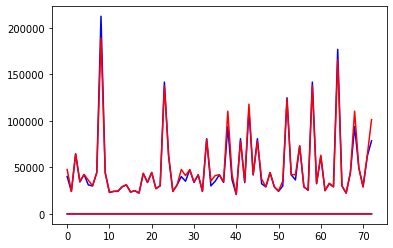

In [53]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor()

# defining parameter range 
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,None ],
              'warm_start': ['True', 'False']
             }
   
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))

# 5. Gaussian Process Regressor (Marcov Chain Monte Carlo) + Grid Search

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-10, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-10, normalize_y=True, score=0.919, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=1e-10, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-10, normalize_y=True, score=0.984, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=1e-10, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-10, normalize_y=True, score=0.956, total=   0.0s
[CV] alpha=1e-10, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-10, normalize_y=False, score=0.780, total=   0.0s
[CV] alpha=1e-10, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-10, normalize_y=False, score=0.944, total=   0.0s
[CV] alpha=1e-10, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-10, normalize_y=False, score=0.857, total=   0.0s
[CV] alpha=1e-09, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-09, normalize_y=True, score=0.919, total=   0.0s
[CV] alpha=1e-09, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-09, normalize_y=True, score=0.984, total=   0.0s
[CV] alpha=1e-09, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-09, normalize_y=True, score=0.956, total=   0.0s
[CV] alpha=1e-09, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-09, normalize_y=False, score=0.780, total=   0.0s
[CV] alpha=1e-09, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-09, normalize_y=False, score=0.944, total=   0.0s
[CV] alpha=1e-09, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-09, normalize_y=False, score=0.857, total=   0.0s
[CV] alpha=1e-05, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-05, normalize_y=True, score=0.919, total=   0.0s
[CV] alpha=1e-05, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-05, normalize_y=True, score=0.984, total=   0.0s
[CV] alpha=1e-05, normalize_y=True ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-05, normalize_y=True, score=0.956, total=   0.0s
[CV] alpha=1e-05, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-05, normalize_y=False, score=0.780, total=   0.0s
[CV] alpha=1e-05, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-05, normalize_y=False, score=0.944, total=   0.0s
[CV] alpha=1e-05, normalize_y=False ..................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-05, normalize_y=False, score=0.857, total=   0.0s
[CV] alpha=0.01, normalize_y=True ....................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ........ alpha=0.01, normalize_y=True, score=0.909, total=   0.0s
[CV] alpha=0.01, normalize_y=True ....................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ........ alpha=0.01, normalize_y=True, score=0.983, total=   0.0s
[CV] alpha=0.01, normalize_y=True ....................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ........ alpha=0.01, normalize_y=True, score=0.951, total=   0.0s
[CV] alpha=0.01, normalize_y=False ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=0.01, normalize_y=False, score=0.763, total=   0.0s
[CV] alpha=0.01, normalize_y=False ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=0.01, normalize_y=False, score=0.941, total=   0.0s
[CV] alpha=0.01, normalize_y=False ...................................


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=0.01, normalize_y=False, score=0.846, total=   0.0s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 1e-10, 'normalize_y': True}
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
MSE =  28732763.61653053
R2 score = 0.9382744616026739

Mean Absolute Percentage Error = [0.11617928 0.52054861]
Mean Absolute Error is: 2466.5528080708627


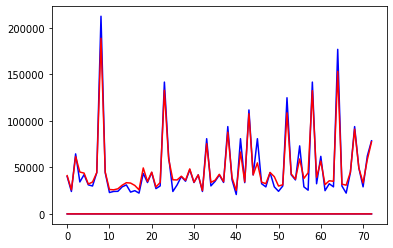

In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0 , 
                               normalize_y= True, copy_X_train=True, random_state= None)
# defining parameter range 
param_grid = {'alpha': [1e-10, 1e-9, 1e-5, 1e-2],  
             'normalize_y' : [True, False],
                         } 
grid = GridSearchCV(gpr, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))